In [44]:
import h5py
import numpy as np
import pandas as pd

# Visualization

In [45]:
H5_PATH = '1m_raw_data_sample/2025-10-01.h5'

In [46]:
# klines
# values_block_0_0 : open
# values_block_0_1 : high
# values_block_0_2 : low
# values_block_0_3 : close
# values_block_0_4 : volume_base
# values_block_0_5 : quote_volume
# values_block_0_6 : taker_buy_volume
# values_block_0_7 : taker_buy_quote_volume
# values_block_1_0 : count

# premiumIndexKlines
# values_block_0_8 : pm_open
# values_block_0_9 : pm_high
# values_block_0_10 : pm_low
# values_block_0_11 : pm_close

# metrics
# -> metrics 는 5분 단위로 집계되나봄 (1분당 데이터가 없음))
# values_block_0_12 : mt_oi (sum_open_interest_value)
# values_block_0_13 : mt_top_ls_ratio_cnt (count_toptrader_long_short_ratio)
# values_block_0_14 : mt_top_ls_ratio (sum_toptrader_long_short_ratio)
# values_block_0_15 : mt_ls_ratio_cnt (count_long_short_ratio)
# values_block_0_16 : mt_ls_ratio (sum_taker_long_short_vol_ratio)

# values_block_2_0 : open_time_ms
# values_block_3_0 : symbol
# values_block_3_1 : open_time_utc

columns = {
    'values_block_0_0': 'open',
    'values_block_0_1': 'high',
    'values_block_0_2': 'low',
    'values_block_0_3': 'close',
    'values_block_0_4': 'volume_base',
    'values_block_0_5': 'quote_volume',
    'values_block_0_6': 'taker_buy_volume',
    'values_block_0_7': 'taker_buy_quote_volume',
    'values_block_0_8': 'pm_open',
    'values_block_0_9': 'pm_high',
    'values_block_0_10': 'pm_low',
    'values_block_0_11': 'pm_close',
    'values_block_0_12': 'mt_oi',
    'values_block_0_13': 'mt_top_ls_ratio_cnt',
    'values_block_0_14': 'mt_top_ls_ratio',
    'values_block_0_15': 'mt_ls_ratio_cnt',
    'values_block_0_16': 'mt_ls_ratio',
        
}

In [47]:
with h5py.File(H5_PATH, 'r') as f:
    ds = f['data']['table']
    ds[:10]

In [48]:
names = ds.dtype.names
for name in names: 
    print(f"{name}: {ds.dtype[name]}")

index: int64
values_block_0: ('<f8', (17,))
values_block_1: ('<i4', (1,))
values_block_2: ('<i8', (1,))
values_block_3: ('S19', (2,))


In [49]:
# Load HDF5 into a pandas DataFrame (two approaches)
import pandas as pd
import numpy as np
import h5py

def compound_to_dataframe(arr):
    names = arr.dtype.names
    cols = {}
    for name in names:
            vals = arr[name]
            # bytes -> str for string fields
            if vals.dtype.kind in {'S','O'}:
                def _decode(x):
                    if isinstance(x, (bytes, bytearray)):
                        try:
                            return x.decode('utf-8', errors='ignore')
                        except Exception:
                            return str(x)
                    return x
                if vals.ndim == 1:
                    cols[name] = [ _decode(x) for x in vals ]
                else:
                    m = vals.shape[1]
                    for j in range(m):
                        cols[f"{name}_{j}"] = [ _decode(x) for x in vals[:, j] ]
            else:
                if vals.ndim == 1:
                    cols[name] = vals
                else:
                    m = vals.shape[1]
                    for j in range(m):
                        cols[f"{name}_{j}"] = vals[:, j]
    return pd.DataFrame(cols)

# Option B: Manual flatten of the compound dataset under /data/table
with h5py.File(H5_PATH, 'r') as f:
    ds = f['data']['table']
    print("/data/table shape:", ds.shape, "dtype:", ds.dtype)
    # For speed in notebooks, preview first N rows; set to None to load all
    N = None  # adjust as needed
    arr = ds[:N] if N is not None else ds[:]
    df = compound_to_dataframe(arr)
    
    # Rename columns using the columns dictionary from cell 2
    df = df.rename(columns=columns)
    
    # Also add mappings for other important columns
    additional_mappings = {
        'values_block_2_0': 'start_time_ms',
        'values_block_3_0': 'symbol',
        'values_block_3_1': 'start_time_utc'
    }
    df = df.rename(columns=additional_mappings)
    
    print(f"Constructed DataFrame with shape {df.shape}")
    display(df.head())

# add close price diff rate for each time step.(종가 대비 변화율)
# maybe there will be no data for the first time step, so fill with 0 or NaN
for symbol in df['symbol'].unique():
    symbol_mask = df['symbol'] == symbol
    df.loc[symbol_mask, 'close_diff_rate'] = df.loc[symbol_mask, 'close'].pct_change().fillna(0)

# Optional: basic info
print("\nDataFrame info:")
df.info(memory_usage='deep')

/data/table shape: (722880,) dtype: [('index', '<i8'), ('values_block_0', '<f8', (17,)), ('values_block_1', '<i4', (1,)), ('values_block_2', '<i8', (1,)), ('values_block_3', 'S19', (2,))]
Constructed DataFrame with shape (722880, 22)


,index,open,high,low,close,volume_base,quote_volume,taker_buy_volume,taker_buy_quote_volume,pm_open,...,pm_close,mt_oi,mt_top_ls_ratio_cnt,mt_top_ls_ratio,mt_ls_ratio_cnt,mt_ls_ratio,values_block_1_0,start_time_ms,symbol,start_time_utc
0,0,2.515900,2.519800,2.512500,2.518300,79820.0,200855.656600,41746.0,105086.650700,-0.008673,...,-0.008242,2.380030e+07,0.681844,0.905235,0.709007,0.691591,2189,1759276800000,0GUSDT,2025-10-01 00:00:00
1,1,0.037960,0.038000,0.037960,0.038000,7719.0,293.261880,7194.0,273.323870,0.000000,...,0.000000,1.052401e+06,3.415902,1.628408,4.080925,0.929852,14,1759276800000,1000000BOBUSDT,2025-10-01 00:00:00
2,2,0.676900,0.678000,0.676900,0.678000,9904.1,6706.803490,9584.7,6490.368390,0.000384,...,0.001115,2.691318e+06,1.724790,1.129305,1.892396,12.153122,66,1759276800000,1000000MOGUSDT,2025-10-01 00:00:00
3,3,0.019151,0.019175,0.019149,0.019164,22741053.0,435729.602255,17934581.0,343639.122727,-0.000189,...,-0.000054,5.022785e+07,1.613701,1.871397,1.529712,1.409590,888,1759276800000,1000BONKUSDT,2025-10-01 00:00:00
4,4,0.007057,0.007066,0.007057,0.007061,1390246.0,9817.851657,1130227.0,7980.862863,0.000654,...,0.000301,3.090472e+06,2.262712,2.565531,2.011894,2.788444,84,1759276800000,1000CATUSDT,2025-10-01 00:00:00



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722880 entries, 0 to 722879
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   index                   722880 non-null  int64  
 1   open                    722880 non-null  float64
 2   high                    722880 non-null  float64
 3   low                     722880 non-null  float64
 4   close                   722880 non-null  float64
 5   volume_base             722880 non-null  float64
 6   quote_volume            722880 non-null  float64
 7   taker_buy_volume        722880 non-null  float64
 8   taker_buy_quote_volume  722880 non-null  float64
 9   pm_open                 722880 non-null  float64
 10  pm_high                 722880 non-null  float64
 11  pm_low                  722880 non-null  float64
 12  pm_close                722880 non-null  float64
 13  mt_oi                   722876 non-null  float64
 14  mt_

In [50]:
crypto_name = df['symbol'].unique()
print("Unique Crypto Names:", len(crypto_name))
print(crypto_name)

Unique Crypto Names: 502
['0GUSDT' '1000000BOBUSDT' '1000000MOGUSDT' '1000BONKUSDT' '1000CATUSDT'
 '1000CHEEMSUSDT' '1000FLOKIUSDT' '1000LUNCUSDT' '1000PEPEUSDT'
 '1000RATSUSDT' '1000SATSUSDT' '1000SHIBUSDT' '1000WHYUSDT' '1000XECUSDT'
 '1000XUSDT' '1INCHUSDT' '1MBABYDOGEUSDT' 'A2ZUSDT' 'AAVEUSDT' 'ACEUSDT'
 'ACHUSDT' 'ACTUSDT' 'ACXUSDT' 'ADAUSDT' 'AERGOUSDT' 'AEROUSDT' 'AEVOUSDT'
 'AGLDUSDT' 'AGTUSDT' 'AI16ZUSDT' 'AIAUSDT' 'AINUSDT' 'AIOTUSDT' 'AIOUSDT'
 'AIUSDT' 'AIXBTUSDT' 'AKEUSDT' 'AKTUSDT' 'ALCHUSDT' 'ALGOUSDT'
 'ALICEUSDT' 'ALLUSDT' 'ALPINEUSDT' 'ALTUSDT' 'ANIMEUSDT' 'ANKRUSDT'
 'APEUSDT' 'API3USDT' 'APTUSDT' 'ARBUSDT' 'ARCUSDT' 'ARIAUSDT' 'ARKMUSDT'
 'ARKUSDT' 'ARPAUSDT' 'ARUSDT' 'ASRUSDT' 'ASTERUSDT' 'ASTRUSDT' 'ATAUSDT'
 'ATHUSDT' 'ATOMUSDT' 'AUCTIONUSDT' 'AUSDT' 'AVAAIUSDT' 'AVAUSDT'
 'AVAXUSDT' 'AVNTUSDT' 'AWEUSDT' 'AXLUSDT' 'AXSUSDT' 'B2USDT' 'B3USDT'
 'BABYUSDT' 'BANANAS31USDT' 'BANANAUSDT' 'BANDUSDT' 'BANKUSDT' 'BANUSDT'
 'BARDUSDT' 'BASUSDT' 'BATUSDT' 'BBUSDT' 'BCHUSDT'

In [51]:
# Want to check if BTCUSDT is in the unique crypto names
if 'BTCUSDT' in crypto_name:
    print("BTCUSDT is present in the dataset.")

BTCUSDT is present in the dataset.


In [52]:
# Want to get data that symbol is 'BTCUSDT' or 'ETHUSDT'
btc_data = df[df['symbol'] == 'BTCUSDT']  # BitCoin
eth_data = df[df['symbol'] == 'ETHUSDT']  # Ethereum
bobu_data = df[df['symbol'] == '1000000BOBUSDT']  # BOBU

In [53]:
# For every crypto in crypto_name, check how many NaN or Null values exist for every column
# Print the crypto name and which column does it have a NaN value if there are any NaN or Null values
for crypto in crypto_name:
    crypto_df = df[df['symbol'] == crypto]
    nan_info = crypto_df.isna().sum()
    nan_columns = nan_info[nan_info > 0]
    if not nan_columns.empty:
        print(f"Crypto: {crypto}")
        for col, count in nan_columns.items():
            print(f"  Column: {col}, NaN Count: {count}")

Crypto: AERGOUSDT
  Column: mt_top_ls_ratio_cnt, NaN Count: 10
  Column: mt_top_ls_ratio, NaN Count: 10
  Column: mt_ls_ratio, NaN Count: 25
Crypto: ANKRUSDT
  Column: mt_ls_ratio, NaN Count: 5
Crypto: ARKUSDT
  Column: mt_ls_ratio, NaN Count: 5
Crypto: BTCDOMUSDT
  Column: mt_oi, NaN Count: 1
  Column: mt_top_ls_ratio_cnt, NaN Count: 1
  Column: mt_top_ls_ratio, NaN Count: 1
  Column: mt_ls_ratio_cnt, NaN Count: 1
  Column: mt_ls_ratio, NaN Count: 1
Crypto: COAIUSDT
  Column: mt_oi, NaN Count: 1
  Column: mt_top_ls_ratio_cnt, NaN Count: 1
  Column: mt_top_ls_ratio, NaN Count: 1
  Column: mt_ls_ratio_cnt, NaN Count: 1
  Column: mt_ls_ratio, NaN Count: 1
Crypto: CROSSUSDT
  Column: mt_ls_ratio, NaN Count: 5
Crypto: CVCUSDT
  Column: mt_ls_ratio, NaN Count: 5
Crypto: DMCUSDT
  Column: mt_ls_ratio, NaN Count: 5
Crypto: ETHWUSDT
  Column: mt_ls_ratio, NaN Count: 5
Crypto: GASUSDT
  Column: mt_ls_ratio, NaN Count: 5
Crypto: GUSDT
  Column: mt_oi, NaN Count: 1
  Column: mt_top_ls_ratio_cnt, 

In [54]:
btc_data.head()

,index,open,high,low,close,volume_base,quote_volume,taker_buy_volume,taker_buy_quote_volume,pm_open,...,mt_oi,mt_top_ls_ratio_cnt,mt_top_ls_ratio,mt_ls_ratio_cnt,mt_ls_ratio,values_block_1_0,start_time_ms,symbol,start_time_utc,close_diff_rate
104,104,113988.7,114045.0,113988.7,114039.0,114.672,1.307525e+07,96.954,1.105488e+07,-0.000515,...,1.009101e+10,1.228302,1.650868,1.068228,1.440637,2321,1759276800000,BTCUSDT,2025-10-01 00:00:00,0.000000
606,606,114039.0,114166.6,114038.9,114116.4,332.542,3.794856e+07,247.616,2.825556e+07,-0.000507,...,1.009101e+10,1.228302,1.650868,1.068228,1.440637,4511,1759276860000,BTCUSDT,2025-10-01 00:01:00,0.000679
1108,1108,114116.3,114120.0,114089.7,114112.9,94.812,1.081886e+07,40.712,4.645477e+06,-0.000511,...,1.009101e+10,1.228302,1.650868,1.068228,1.440637,1573,1759276920000,BTCUSDT,2025-10-01 00:02:00,-0.000031
1610,1610,114112.9,114116.2,114096.3,114112.3,78.905,9.003572e+06,32.962,3.761056e+06,-0.000457,...,1.009101e+10,1.228302,1.650868,1.068228,1.440637,1377,1759276980000,BTCUSDT,2025-10-01 00:03:00,-0.000005
2112,2112,114112.4,114166.8,114090.8,114166.8,92.484,1.055298e+07,36.848,4.204848e+06,-0.000441,...,1.009101e+10,1.228302,1.650868,1.068228,1.440637,1750,1759277040000,BTCUSDT,2025-10-01 00:04:00,0.000478


In [55]:
eth_data.head()

,index,open,high,low,close,volume_base,quote_volume,taker_buy_volume,taker_buy_quote_volume,pm_open,...,mt_oi,mt_top_ls_ratio_cnt,mt_top_ls_ratio,mt_ls_ratio_cnt,mt_ls_ratio,values_block_1_0,start_time_ms,symbol,start_time_utc,close_diff_rate
171,171,4142.75,4145.14,4141.46,4144.27,2537.604,1.051484e+07,1414.282,5.860486e+06,-0.000635,...,7.572309e+09,2.479895,2.777486,2.110907,0.784762,4494,1759276800000,ETHUSDT,2025-10-01 00:00:00,0.000000
673,673,4144.28,4148.62,4144.28,4148.13,2840.669,1.178055e+07,1998.352,8.287171e+06,-0.000636,...,7.572309e+09,2.479895,2.777486,2.110907,0.784762,4901,1759276860000,ETHUSDT,2025-10-01 00:01:00,0.000931
1175,1175,4148.13,4148.35,4146.60,4147.91,1948.139,8.080199e+06,1268.849,5.262641e+06,-0.000675,...,7.572309e+09,2.479895,2.777486,2.110907,0.784762,2803,1759276920000,ETHUSDT,2025-10-01 00:02:00,-0.000053
1677,1677,4147.90,4149.08,4146.21,4146.21,2024.947,8.398792e+06,1035.696,4.295769e+06,-0.000626,...,7.572309e+09,2.479895,2.777486,2.110907,0.784762,3157,1759276980000,ETHUSDT,2025-10-01 00:03:00,-0.000410
2179,2179,4146.20,4149.09,4145.76,4149.09,1144.532,4.746114e+06,615.829,2.553864e+06,-0.000732,...,7.572309e+09,2.479895,2.777486,2.110907,0.784762,2465,1759277040000,ETHUSDT,2025-10-01 00:04:00,0.000695


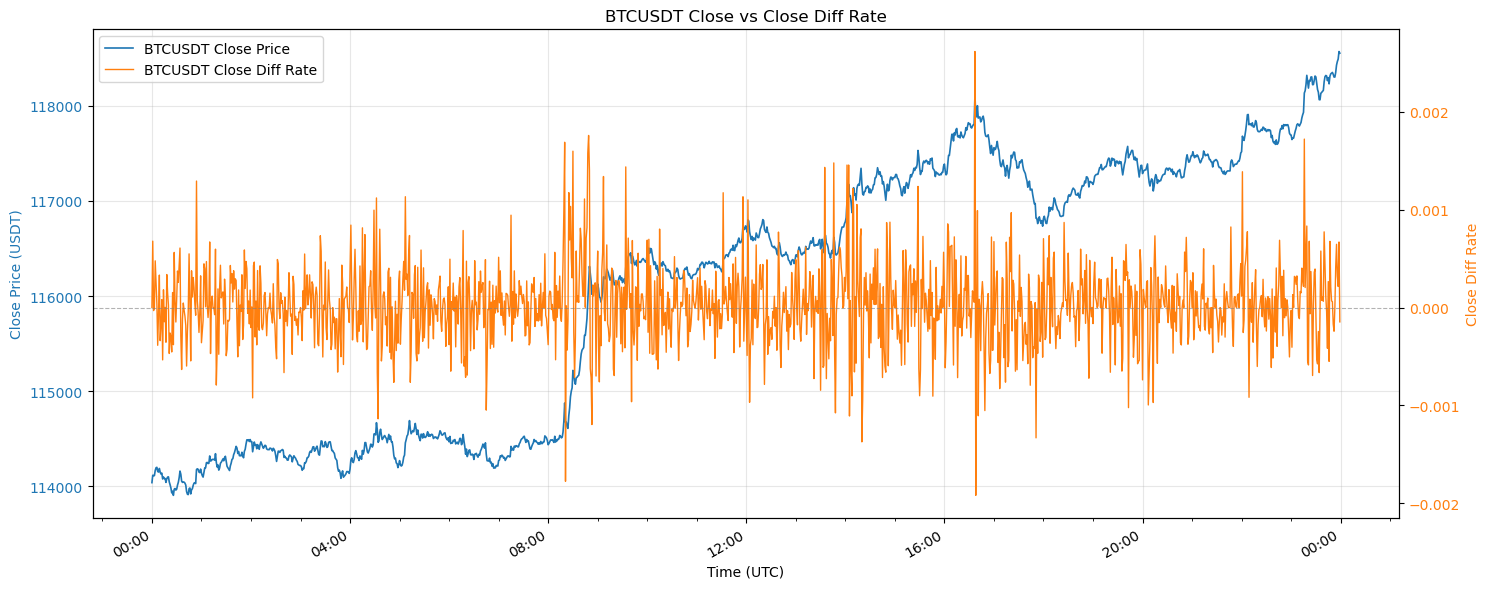

Plotted 1440 data points for BTCUSDT


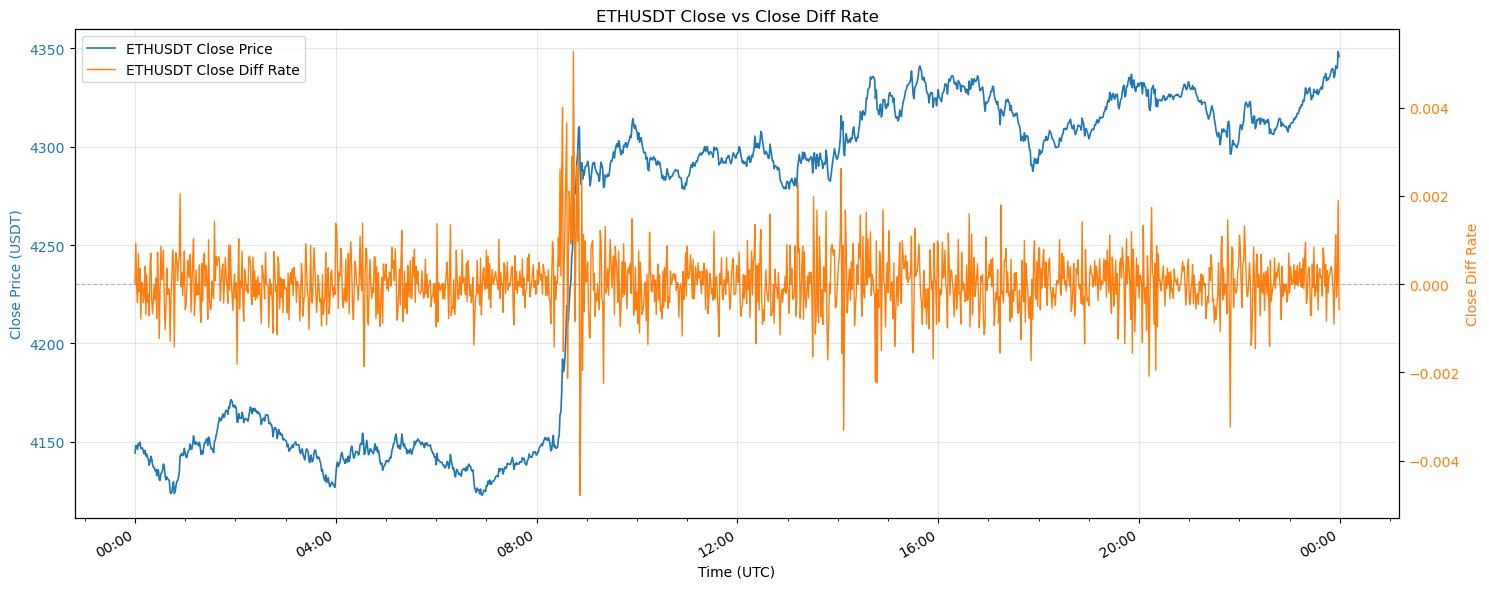

Plotted 1440 data points for ETHUSDT


In [56]:
# Function to plot close price and diff rate on dual y-axes for any cryptocurrency symbol
# The left y-axis shows the close price; the right y-axis shows the close_diff_rate.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_close_price(symbol_name, data_df):
    """
    Plot close price and close_diff_rate over time for a given cryptocurrency symbol on dual y-axes.

    Args:
        symbol_name (str): Name of the cryptocurrency symbol (e.g., 'BTCUSDT', 'ETHUSDT')
        data_df (pd.DataFrame): Full dataframe containing all symbols
    """
    # Filter data for the specific symbol
    symbol_data = data_df[data_df['symbol'] == symbol_name].copy()

    if symbol_data.empty:
        print(f"No data found for symbol: {symbol_name}")
        return

    # Convert string timestamps to datetime objects for better handling
    symbol_data['datetime'] = pd.to_datetime(symbol_data['start_time_utc'])

    # Create single plot with twin y-axes
    fig, ax1 = plt.subplots(figsize=(15, 6))

    color_price = 'tab:blue'
    color_diff = 'tab:orange'

    # Left axis: Close Price
    ln1 = ax1.plot(
        symbol_data['datetime'], symbol_data['close'],
        label=f'{symbol_name} Close Price', linewidth=1.2, color=color_price
    )
    ax1.set_xlabel('Time (UTC)')
    ax1.set_ylabel('Close Price (USDT)', color=color_price)
    ax1.tick_params(axis='y', labelcolor=color_price)

    # Right axis: Close Diff Rate
    ax2 = ax1.twinx()
    ln2 = ax2.plot(
        symbol_data['datetime'], symbol_data['close_diff_rate'],
        label=f'{symbol_name} Close Diff Rate', linewidth=1.0, color=color_diff
    )
    ax2.set_ylabel('Close Diff Rate', color=color_diff)
    ax2.tick_params(axis='y', labelcolor=color_diff)
    ax2.axhline(0.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

    # Use matplotlib date formatting to show fewer, cleaner labels
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=4))  # Show every 4 hours
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM
    ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=1))   # Minor ticks every hour

    fig.autofmt_xdate()
    ax1.grid(True, alpha=0.3)

    # Combined legend from both axes
    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper left')

    plt.title(f'{symbol_name} Close vs Close Diff Rate')
    plt.tight_layout()
    plt.show()

    print(f"Plotted {len(symbol_data)} data points for {symbol_name}")

# Example usage: Plot BTC
plot_close_price('BTCUSDT', df)
plot_close_price('ETHUSDT', df)

Creating dashboard for BTCUSDT:


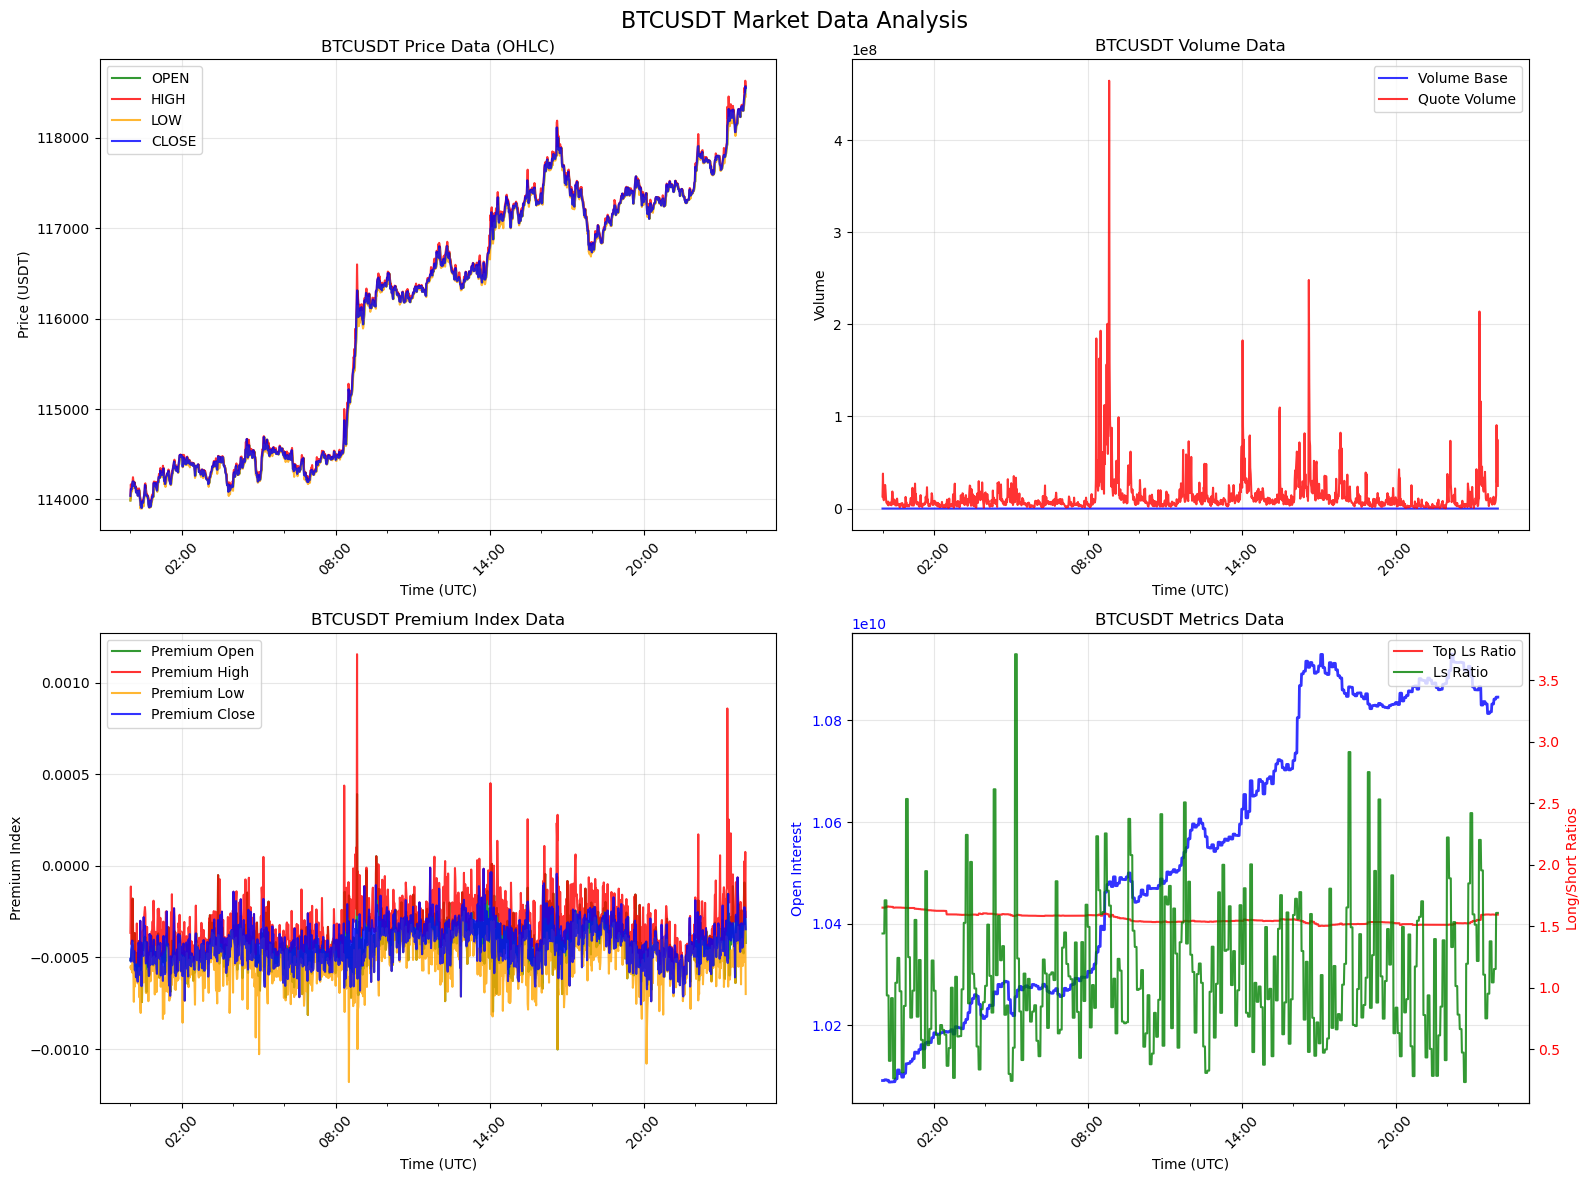

Dashboard created for BTCUSDT with 1440 data points

Creating dashboard for ETHUSDT:


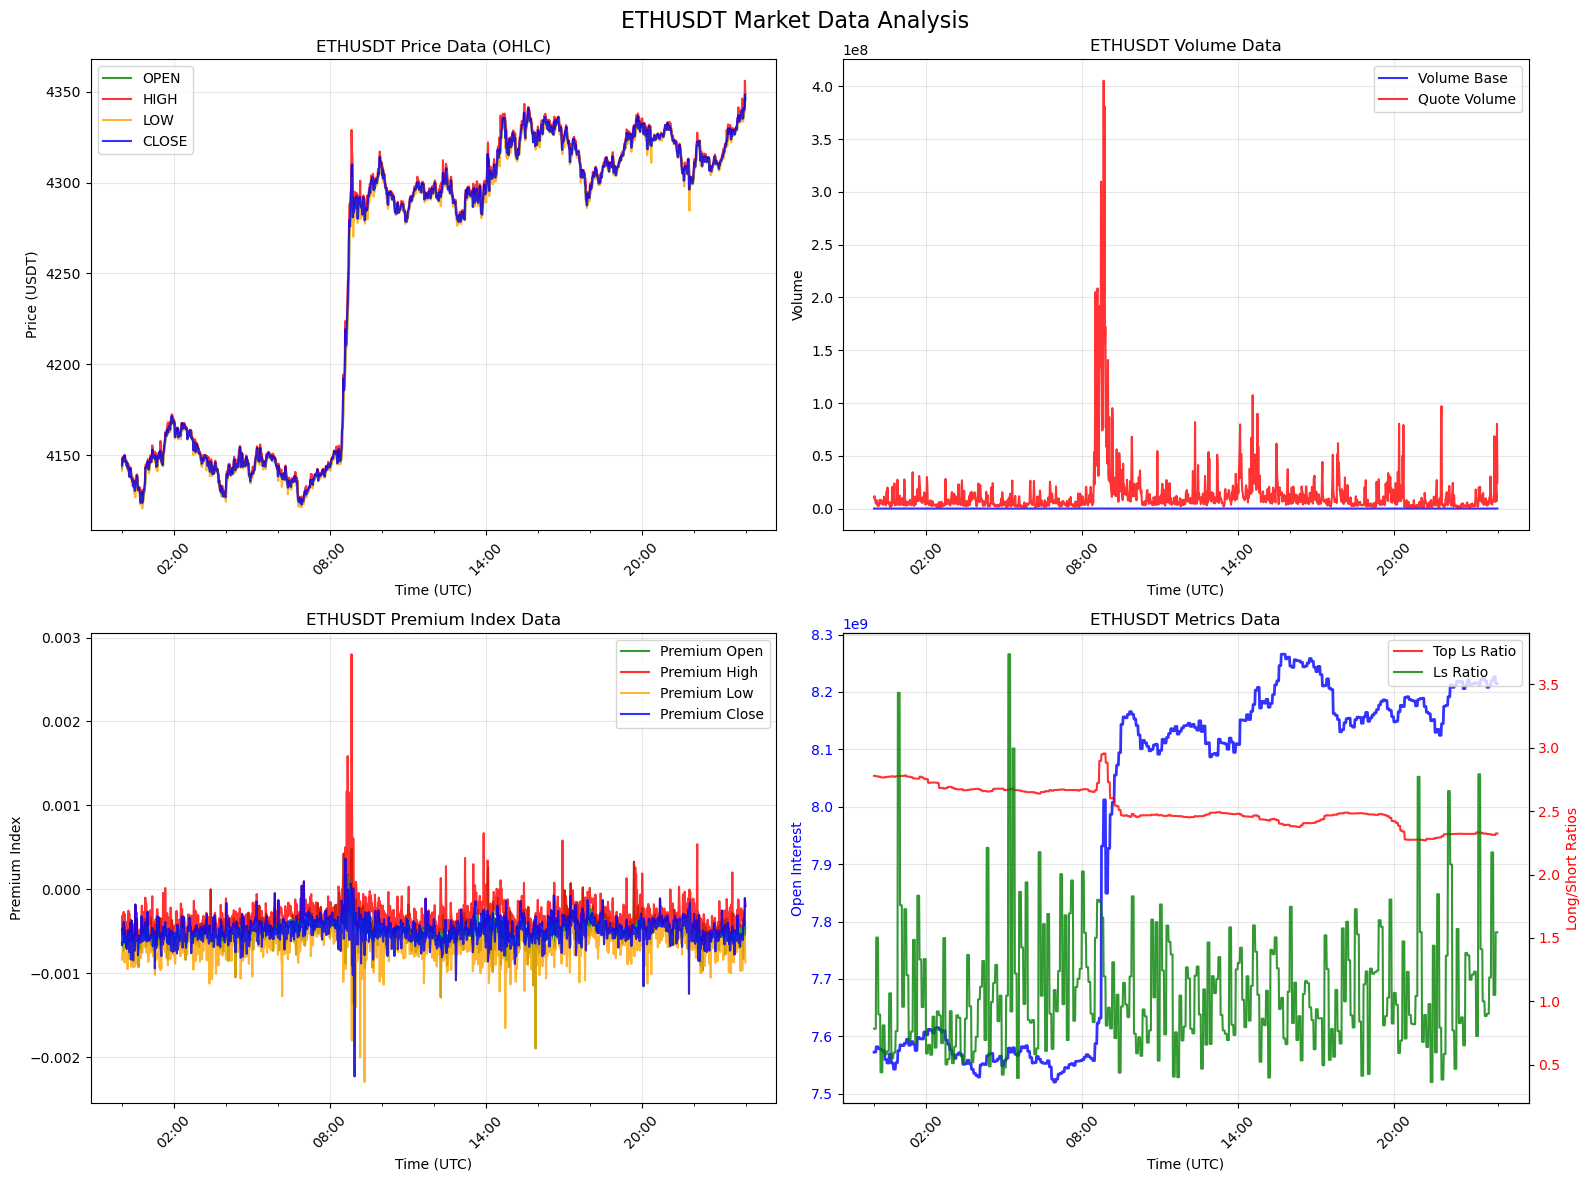

Dashboard created for ETHUSDT with 1440 data points


In [57]:
# Function to create comprehensive market data dashboard for any cryptocurrency symbol
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_market_dashboard(symbol_name, data_df):
    """
    Create a comprehensive market data dashboard for a given cryptocurrency symbol
    
    Args:
        symbol_name (str): Name of the cryptocurrency symbol (e.g., 'BTCUSDT', 'ETHUSDT')
        data_df (pd.DataFrame): Full dataframe containing all symbols
    """
    # Filter data for the specific symbol
    symbol_data = data_df[data_df['symbol'] == symbol_name].copy()
    
    if symbol_data.empty:
        print(f"No data found for symbol: {symbol_name}")
        return
    
    # Convert string timestamps to datetime objects for better handling
    symbol_data['datetime'] = pd.to_datetime(symbol_data['start_time_utc'])
    
    # Define the columns we want to plot
    price_columns = ['open', 'high', 'low', 'close']
    volume_columns = ['volume_base', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']
    premium_columns = ['pm_open', 'pm_high', 'pm_low', 'pm_close']
    
    # Create the figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{symbol_name} Market Data Analysis', fontsize=16)
    
    # Function to format x-axis for each subplot
    def format_xaxis(ax):
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Every 6 hours
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # HH:MM format
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))   # Minor ticks every 2 hours
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    # Plot 1: Price data
    ax1 = axes[0, 0]
    colors = ['green', 'red', 'orange', 'blue']
    for i, col in enumerate(price_columns):
        if col in symbol_data.columns:
            ax1.plot(symbol_data['datetime'], symbol_data[col], 
                    label=col.upper(), alpha=0.8, color=colors[i])
    ax1.set_xlabel('Time (UTC)')
    ax1.set_ylabel('Price (USDT)')
    ax1.set_title(f'{symbol_name} Price Data (OHLC)')
    ax1.legend()
    format_xaxis(ax1)
    
    # Plot 2: Volume data
    ax2 = axes[0, 1]
    main_volumes = ['volume_base', 'quote_volume']  # Only plot main volumes to avoid clutter
    colors_vol = ['blue', 'red']
    for i, col in enumerate(main_volumes):
        if col in symbol_data.columns:
            ax2.plot(symbol_data['datetime'], symbol_data[col], 
                    label=col.replace('_', ' ').title(), alpha=0.8, color=colors_vol[i])
    ax2.set_xlabel('Time (UTC)')
    ax2.set_ylabel('Volume')
    ax2.set_title(f'{symbol_name} Volume Data')
    ax2.legend()
    format_xaxis(ax2)
    
    # Plot 3: Premium index data
    ax3 = axes[1, 0]
    colors_prem = ['green', 'red', 'orange', 'blue']
    has_premium_data = False
    for i, col in enumerate(premium_columns):
        if col in symbol_data.columns and not symbol_data[col].isna().all():
            ax3.plot(symbol_data['datetime'], symbol_data[col], 
                    label=col.replace('pm_', 'Premium ').title(), alpha=0.8, color=colors_prem[i])
            has_premium_data = True
    
    if has_premium_data:
        ax3.set_xlabel('Time (UTC)')
        ax3.set_ylabel('Premium Index')
        ax3.set_title(f'{symbol_name} Premium Index Data')
        ax3.legend()
        format_xaxis(ax3)
    else:
        ax3.text(0.5, 0.5, 'No Premium Data Available', 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title(f'{symbol_name} Premium Index Data')
    
    # Plot 4: Metrics data with dual y-axis
    ax4 = axes[1, 1]
    has_metrics_data = False
    
    # Primary y-axis for Open Interest
    if 'mt_oi' in symbol_data.columns and not symbol_data['mt_oi'].isna().all():
        ax4.plot(symbol_data['datetime'], symbol_data['mt_oi'], 
                label='Open Interest', color='blue', alpha=0.8, linewidth=2)
        ax4.set_ylabel('Open Interest', color='blue')
        ax4.tick_params(axis='y', labelcolor='blue')
        has_metrics_data = True
        
        # Secondary y-axis for ratios
        ax4_twin = ax4.twinx()
        colors_metrics = ['red', 'green']
        ratio_cols = ['mt_top_ls_ratio', 'mt_ls_ratio']
        
        for i, col in enumerate(ratio_cols):
            if col in symbol_data.columns and not symbol_data[col].isna().all():
                ax4_twin.plot(symbol_data['datetime'], symbol_data[col], 
                             label=col.replace('mt_', '').replace('_', ' ').title(), 
                             color=colors_metrics[i], alpha=0.8)
        
        ax4_twin.set_ylabel('Long/Short Ratios', color='red')
        ax4_twin.tick_params(axis='y', labelcolor='red')
        ax4_twin.legend(loc='upper right')
        
        ax4.set_xlabel('Time (UTC)')
        format_xaxis(ax4)
    
    if not has_metrics_data:
        ax4.text(0.5, 0.5, 'No Metrics Data Available', 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax4.transAxes, fontsize=12)
    
    ax4.set_title(f'{symbol_name} Metrics Data')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Dashboard created for {symbol_name} with {len(symbol_data)} data points")

# Example usage: Create dashboard for different symbols
print("Creating dashboard for BTCUSDT:")
plot_market_dashboard('BTCUSDT', df)

print("\nCreating dashboard for ETHUSDT:")
plot_market_dashboard('ETHUSDT', df)

# Concatenating Data

In [58]:
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

DATA_DIR = Path("1m_raw_data_sample")  # adjust folder
DATE_FMT = "%Y-%m-%d"

start_date = datetime.strptime("2025-09-30", DATE_FMT) # start date as input
end_date = datetime.strptime("2025-10-02", DATE_FMT)   # end date as input

window_size = 1200 # window size as input

In [59]:
def iter_dates(start, end):
    d = start
    while d <= end: 
        yield d
        d += timedelta(days=1)

frames = [] 
for d in iter_dates(start_date, end_date):
    file_path = DATA_DIR / f"{d.strftime(DATE_FMT)}.h5"
    if not file_path.exists():
        print("File not found: ", file_path)
        continue
    try: 
        df_day = pd.read_hdf(file_path, key="data")
        frames.append(df_day)
        print("Loaded: ", file_path)
    except Exception as e:
        print("Error loading ", file_path, ":", e)

if frames: 
    concat_df = pd.concat(frames, ignore_index=True) 
    concat_df = concat_df.sort_values(["symbol","start_time_ms"]).reset_index(drop=True)
else: 
    concat_df = pd.DataFrame()  # empty dataframe

print("Final || rows: ", len(concat_df), "symbols:", concat_df.symbol.nunique())

Loaded:  1m_raw_data_sample/2025-09-30.h5
Loaded:  1m_raw_data_sample/2025-10-01.h5
Loaded:  1m_raw_data_sample/2025-10-02.h5
Final || rows:  2168640 symbols: 504


In [60]:
concat_df[concat_df['symbol']=='BTCUSDT'].head(5)

,symbol,start_time_ms,start_time_utc,open,high,low,close,volume_base,quote_volume,num_trades,...,taker_buy_quote,pm_open,pm_high,pm_low,pm_close,mt_oi,mt_top_ls_ratio_cnt,mt_top_ls_ratio,mt_ls_ratio_cnt,mt_ls_vol_ratio
449280,BTCUSDT,1759190400000,2025-09-30 00:00:00,114257.1,114257.1,114148.6,114200.1,488.979,5.584198e+07,6269,...,8.933181e+06,-0.000540,-0.000432,-0.000731,-0.000505,1.015404e+10,1.112329,1.547386,1.022714,1.50413
449281,BTCUSDT,1759190460000,2025-09-30 00:01:00,114200.0,114223.9,114177.8,114221.9,66.945,7.644568e+06,1626,...,3.601286e+06,-0.000505,-0.000322,-0.000540,-0.000381,1.015404e+10,1.112329,1.547386,1.022714,1.50413
449282,BTCUSDT,1759190520000,2025-09-30 00:02:00,114222.0,114222.0,114196.5,114196.6,27.633,3.155975e+06,785,...,3.893262e+05,-0.000425,-0.000425,-0.000570,-0.000503,1.015404e+10,1.112329,1.547386,1.022714,1.50413
449283,BTCUSDT,1759190580000,2025-09-30 00:03:00,114196.5,114203.5,114192.5,114192.6,36.930,4.217396e+06,760,...,1.127453e+06,-0.000562,-0.000505,-0.000562,-0.000520,1.015404e+10,1.112329,1.547386,1.022714,1.50413
449284,BTCUSDT,1759190640000,2025-09-30 00:04:00,114192.6,114207.5,114192.6,114207.5,19.942,2.277409e+06,821,...,9.956121e+05,-0.000520,-0.000446,-0.000520,-0.000471,1.015404e+10,1.112329,1.547386,1.022714,1.50413


# Universal y generator  

In [61]:
# Build target y for each symbol using window_size, start_date, end_date on concat_df

from typing import Optional

def build_target_y(df: pd.DataFrame, window_size: int, preview: bool = True,
                   preview_symbol: Optional[str] = None, inplace: bool = False) -> pd.DataFrame:
    """
     Given: input window size(w), start_date, end_date

     First concatenate all hdf5 files between start_date and end_date into a single dataframe => concat_df
     Then for window size w, generate y 
     fill the first w rows with 0 or NaN as there is no previous data to compare
     Rest will be the value right after the window of
     (actual close_diff_rate for that symbol - the universe mean close_diff_rate in symbol wise) 
    """
    if df is None or len(df) == 0:
        raise ValueError("Input DataFrame is empty; concatenate data first.")

    work = df if inplace else df.copy()

    # Ensure sorting (symbol, time)
    work = work.sort_values(["symbol", "start_time_ms"]).reset_index(drop=True)

    # Ensure close_diff_rate exists (symbol-wise pct_change of close)
    if "close_diff_rate" not in work.columns:
        work["close_diff_rate"] = (
            work.groupby("symbol")["close"].pct_change().fillna(0.0)
        )

    # Cross-sectional (universe) mean of close_diff_rate per timestamp
    universal_mean = work.groupby("start_time_ms")["close_diff_rate"].mean()
    work["cs_mean"] = work["start_time_ms"].map(universal_mean)

    # Target is the next-step symbol cdr minus next-step cross-sectional mean
    work["cdr_next"] = work.groupby("symbol")["close_diff_rate"].shift(-1)
    work["cs_mean_next"] = work.groupby("symbol")["cs_mean"].shift(-1)
    work["y"] = work["cdr_next"] - work["cs_mean_next"]

    # For windows of length w, keep only rows that have at least w prior observations
    # Fill first w rows per symbol with NaN, as requested
    w = max(1, int(window_size))
    first_w_mask = work.groupby("symbol").cumcount() < w
    work.loc[first_w_mask, "y"] = np.nan

    # Cleanup temporary columns
    work.drop(columns=["cs_mean", "cdr_next", "cs_mean_next"], inplace=True)

    # quick preview for a symbol if available
    if preview:
        if preview_symbol is None:
            preview_symbol = "BTCUSDT" if "BTCUSDT" in work["symbol"].unique() else work["symbol"].iloc[0]
        print("Preview for symbol:", preview_symbol)
        print(work.loc[work["symbol"] == preview_symbol, ["symbol", "start_time_utc", "close_diff_rate", "y"]].head(w + 5))

    return work if not inplace else df

# Usage: compute y and overwrite concat_df
concat_df = build_target_y(concat_df, window_size, preview=True, preview_symbol=None, inplace=False)

Preview for symbol: BTCUSDT
         symbol       start_time_utc  close_diff_rate         y
449280  BTCUSDT  2025-09-30 00:00:00         0.000000       NaN
449281  BTCUSDT  2025-09-30 00:01:00         0.000191       NaN
449282  BTCUSDT  2025-09-30 00:02:00        -0.000221       NaN
449283  BTCUSDT  2025-09-30 00:03:00        -0.000035       NaN
449284  BTCUSDT  2025-09-30 00:04:00         0.000130       NaN
...         ...                  ...              ...       ...
450480  BTCUSDT  2025-09-30 20:00:00         0.001204 -0.000925
450481  BTCUSDT  2025-09-30 20:01:00        -0.000518  0.000420
450482  BTCUSDT  2025-09-30 20:02:00        -0.001096  0.000368
450483  BTCUSDT  2025-09-30 20:03:00        -0.000486 -0.000055
450484  BTCUSDT  2025-09-30 20:04:00         0.000552  0.000297

[1205 rows x 4 columns]


In [62]:
# Visualize target y over time for a specific symbol across the full date range
import matplotlib.dates as mdates

SYMBOL = "ETHUSDT"  # change as needed


def _to_utc_ts(dt_like):
    ts = pd.Timestamp(dt_like)
    if ts.tzinfo is None:
        return ts.tz_localize("UTC")
    return ts.tz_convert("UTC")


def visualize_target_y(symbol=SYMBOL, start=None, end=None):
    """
    Visualize target y over time for a specific cryptocurrency symbol.

    Args:
        symbol (str): Cryptocurrency symbol to visualize (e.g., 'BTCUSDT', 'ETHUSDT')
        start, end: Optional datetime-like boundaries; if None, use global start_date/end_date.
                    The x-axis will be fixed to cover the entire [start, end] window.
    """

    # Sanity checks
    try:
        _ = concat_df
    except NameError:
        raise RuntimeError("concat_df is not defined. Run the concatenation cell first.")

    if "y" not in concat_df.columns:
        raise RuntimeError("Target 'y' not found. Run the target-generation cell above first.")

    sym_df = concat_df[concat_df["symbol"] == symbol].copy()
    if sym_df.empty:
        print(f"No rows for symbol {symbol}.")
        return

    # Build UTC timestamp for plotting
    if "start_time_ms" in sym_df.columns:
        sym_df["ts_utc"] = pd.to_datetime(sym_df["start_time_ms"], unit="ms", utc=True)
    elif "start_time_utc" in sym_df.columns:
        sym_df["ts_utc"] = pd.to_datetime(sym_df["start_time_utc"], utc=True)
    else:
        raise RuntimeError("No time column found (start_time_ms/start_time_utc)")

    # Determine plot boundaries
    if start is None:
        try:
            plot_start = _to_utc_ts(start_date)
        except Exception:
            plot_start = sym_df["ts_utc"].min().floor("D")
    else:
        plot_start = _to_utc_ts(start)

    if end is None:
        try:
            plot_end = _to_utc_ts(end_date)
        except Exception:
            plot_end = sym_df["ts_utc"].max().ceil("D")
    else:
        plot_end = _to_utc_ts(end)

    # Make end exclusive end-of-day to show the full last day on the axis
    plot_end = (plot_end + pd.Timedelta(days=1)).normalize()

    # Drop NaNs in y for plotting
    sym_df_nonan = sym_df.dropna(subset=["y"]).copy()

    # Preview table
    display(sym_df_nonan[["symbol", "ts_utc", "y"]].head(10))

    # Plot
    plt.figure(figsize=(14, 4))
    plt.plot(sym_df_nonan["ts_utc"], sym_df_nonan["y"], label=f"{symbol} y", linewidth=1.0)
    plt.axhline(0.0, color="gray", linewidth=0.8, linestyle="--", alpha=0.7)
    plt.title(f"{symbol} target y over time")
    plt.xlabel("UTC time")
    plt.ylabel("y (excess return)")
    ax = plt.gca()

    # Choose tick density based on span
    span_days = (plot_end - plot_start) / pd.Timedelta(days=1)
    if span_days <= 3:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

    ax.set_xlim([plot_start, plot_end])
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

,symbol,ts_utc,y
450480,BTCUSDT,2025-09-30 20:00:00+00:00,-0.000925
450481,BTCUSDT,2025-09-30 20:01:00+00:00,0.000420
450482,BTCUSDT,2025-09-30 20:02:00+00:00,0.000368
450483,BTCUSDT,2025-09-30 20:03:00+00:00,-0.000055
450484,BTCUSDT,2025-09-30 20:04:00+00:00,0.000297
450485,BTCUSDT,2025-09-30 20:05:00+00:00,-0.000953
450486,BTCUSDT,2025-09-30 20:06:00+00:00,-0.001837
450487,BTCUSDT,2025-09-30 20:07:00+00:00,0.000748
450488,BTCUSDT,2025-09-30 20:08:00+00:00,-0.000029
450489,BTCUSDT,2025-09-30 20:09:00+00:00,0.000373


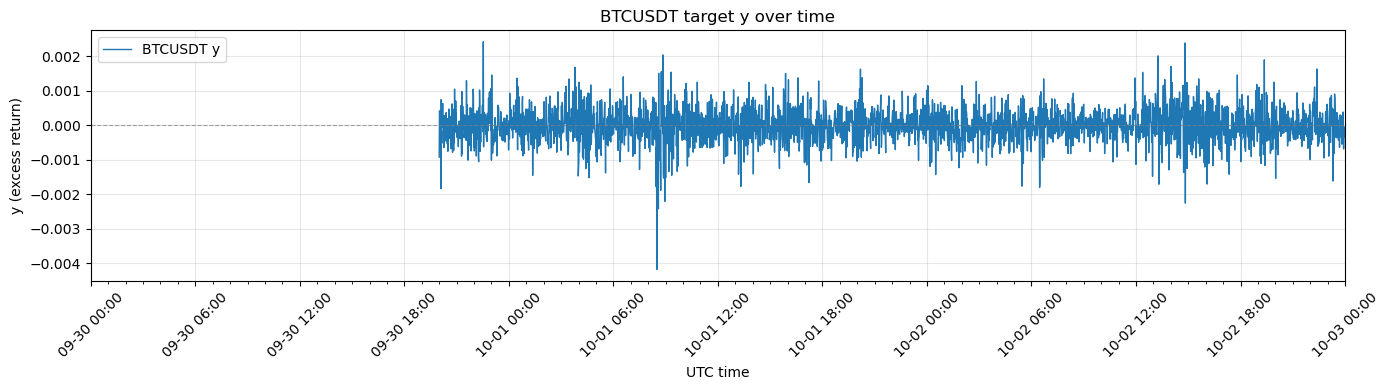

,symbol,ts_utc,y
738480,ETHUSDT,2025-09-30 20:00:00+00:00,-0.000709
738481,ETHUSDT,2025-09-30 20:01:00+00:00,-0.000528
738482,ETHUSDT,2025-09-30 20:02:00+00:00,-0.000085
738483,ETHUSDT,2025-09-30 20:03:00+00:00,-0.000323
738484,ETHUSDT,2025-09-30 20:04:00+00:00,0.000935
738485,ETHUSDT,2025-09-30 20:05:00+00:00,-0.000529
738486,ETHUSDT,2025-09-30 20:06:00+00:00,-0.000872
738487,ETHUSDT,2025-09-30 20:07:00+00:00,0.000429
738488,ETHUSDT,2025-09-30 20:08:00+00:00,0.000117
738489,ETHUSDT,2025-09-30 20:09:00+00:00,-0.000493


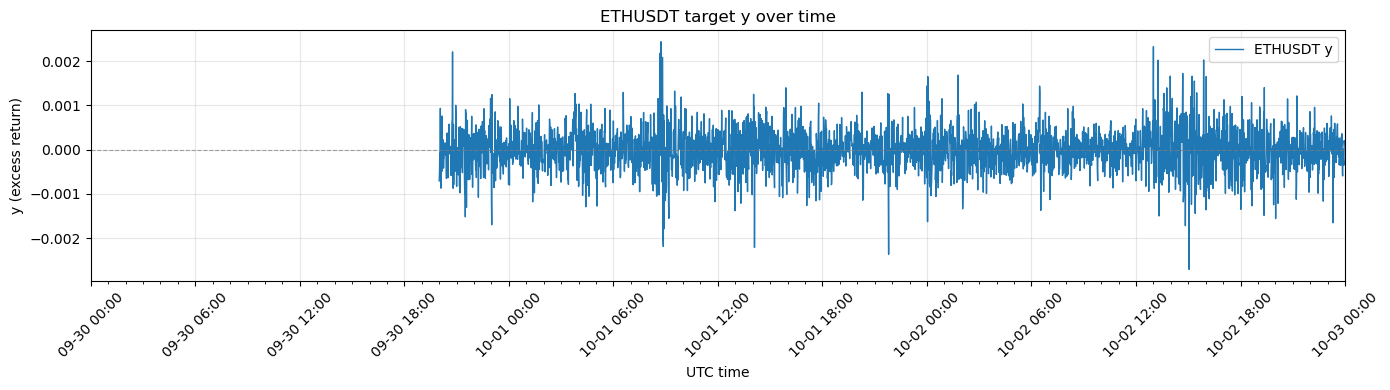

In [63]:
# Draw for the full start_date..end_date window
visualize_target_y("BTCUSDT", start=start_date, end=end_date)
visualize_target_y("ETHUSDT", start=start_date, end=end_date)

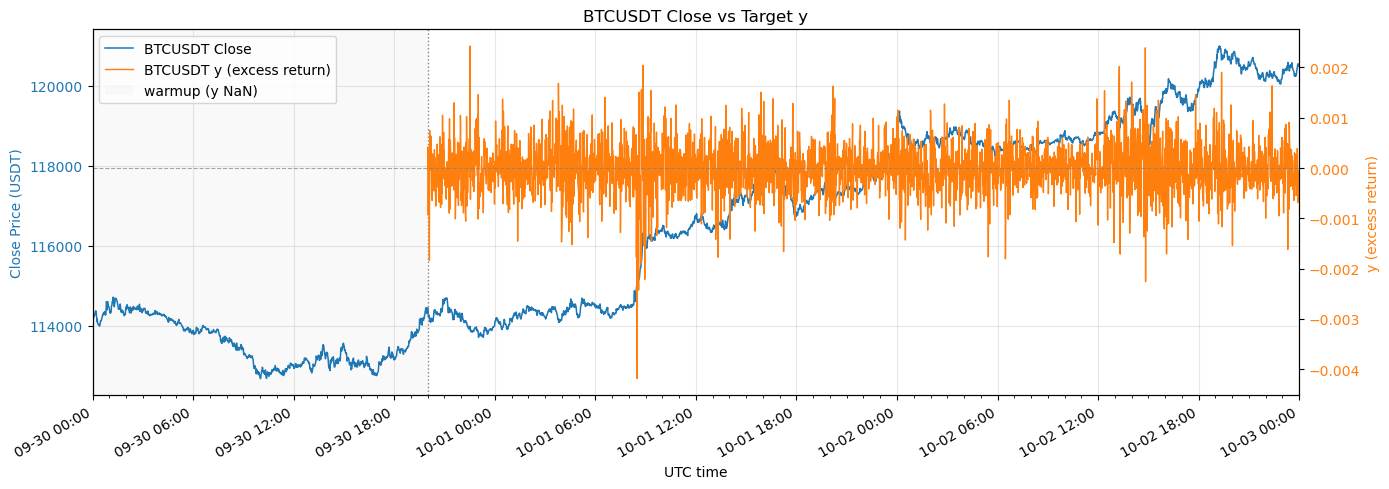

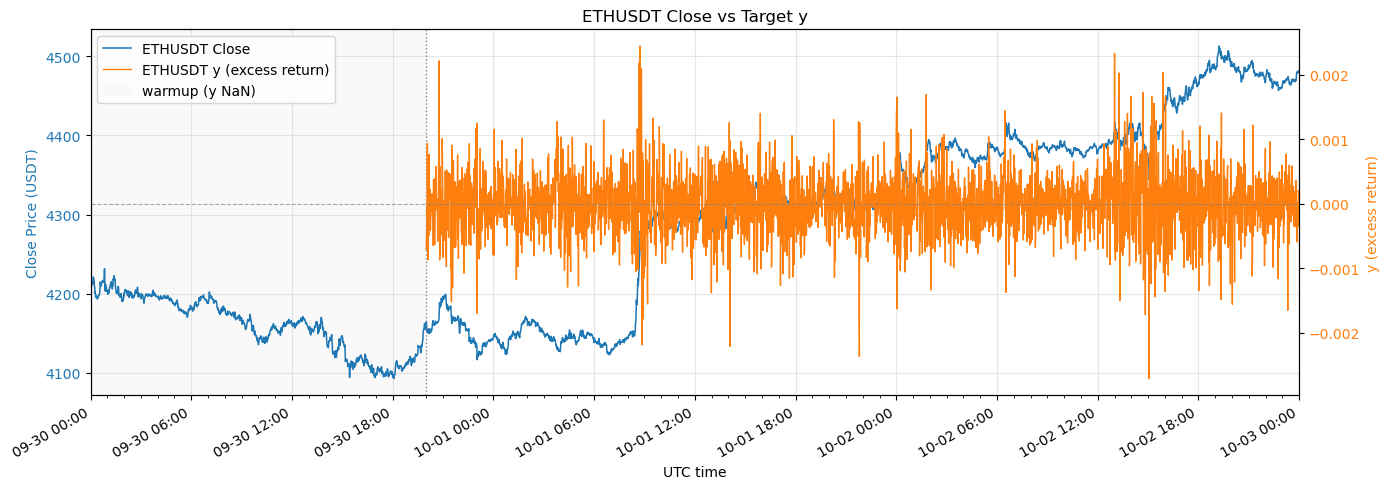

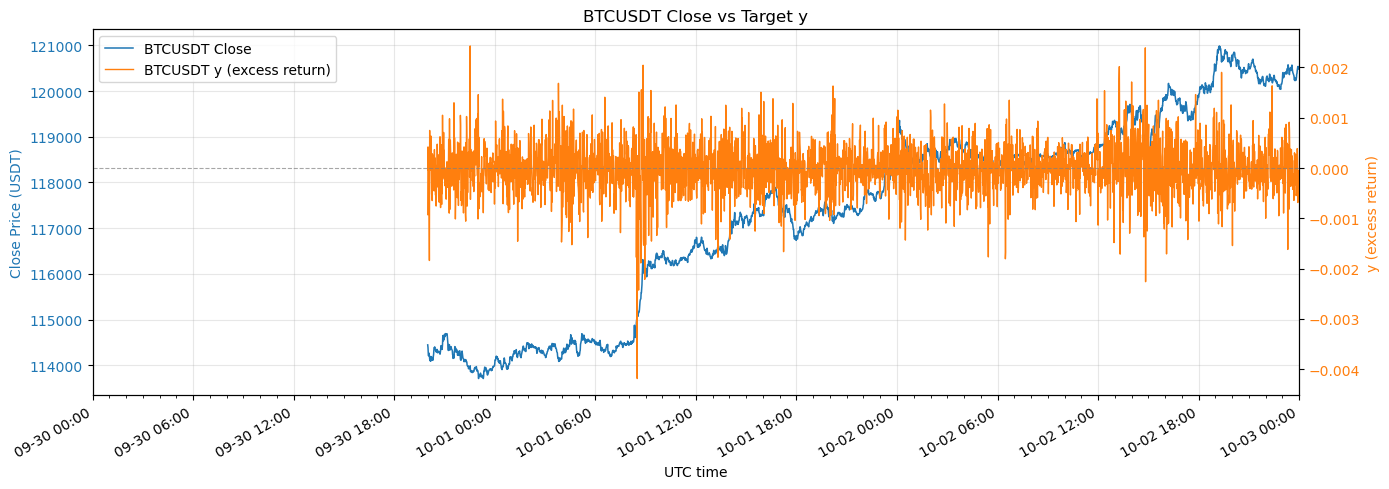

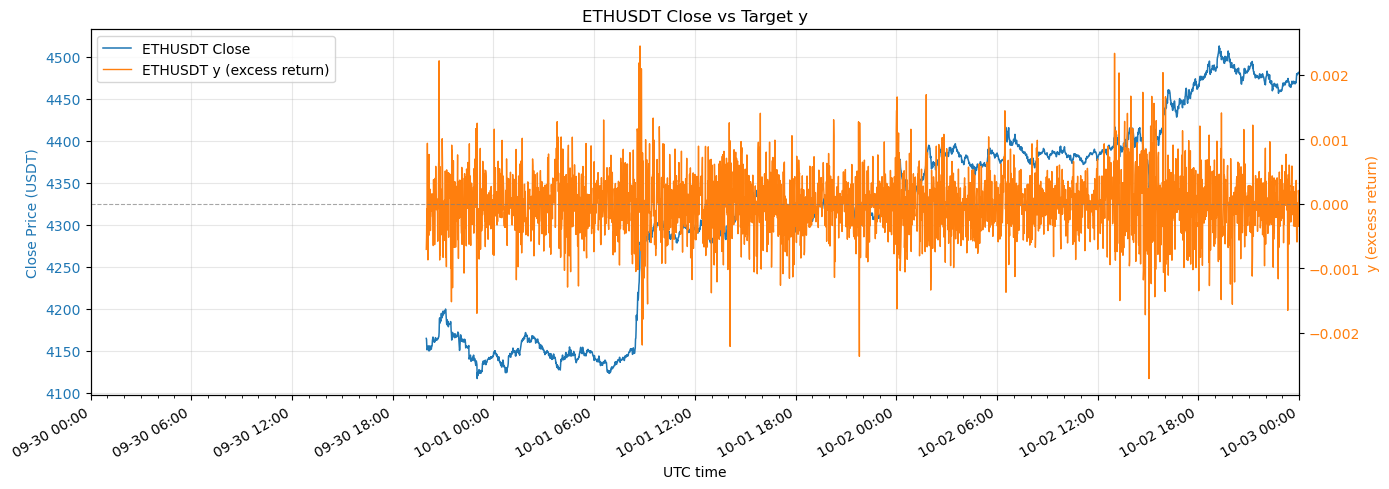

In [64]:
# Plot close price (left) and target y (right) on the same chart across full date range
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


def _to_utc_ts(dt_like):
    ts = pd.Timestamp(dt_like)
    if ts.tzinfo is None:
        return ts.tz_localize("UTC")
    return ts.tz_convert("UTC")


def plot_price_and_target_y(
    symbol,
    start=None,
    end=None,
    data=None,
    trim_to_y: bool = False,
    shade_warmup: bool = True,
    warmup_color: str = "#f0f0f0",
):
    """
    Plot close price (left y-axis) and target y (right y-axis) for a symbol over time.
    """
    # Choose data source
    if data is None:
        try:
            data = concat_df
        except NameError:
            raise RuntimeError("concat_df is not defined. Run the concatenation and target cells first.")

    # Checks
    needed_cols = {"symbol", "close", "y"}
    if not needed_cols.issubset(set(data.columns)):
        missing = needed_cols.difference(set(data.columns))
        raise RuntimeError(f"Missing columns in data: {missing}. Ensure target 'y' is computed.")

    sym_df = data[data["symbol"] == symbol].copy()
    if sym_df.empty:
        print(f"No rows for symbol {symbol}.")
        return

    # Build UTC timestamp
    if "start_time_ms" in sym_df.columns:
        sym_df["ts_utc"] = pd.to_datetime(sym_df["start_time_ms"], unit="ms", utc=True)
    elif "start_time_utc" in sym_df.columns:
        sym_df["ts_utc"] = pd.to_datetime(sym_df["start_time_utc"], utc=True)
    else:
        raise RuntimeError("No time column found (start_time_ms/start_time_utc)")

    # Boundaries
    if start is None:
        try:
            plot_start = _to_utc_ts(start_date)
        except Exception:
            plot_start = sym_df["ts_utc"].min().floor("D")
    else:
        plot_start = _to_utc_ts(start)

    if end is None:
        try:
            plot_end = _to_utc_ts(end_date)
        except Exception:
            plot_end = sym_df["ts_utc"].max().ceil("D")
    else:
        plot_end = _to_utc_ts(end)

    # Extend end to include full last day visually
    plot_end = (plot_end + pd.Timedelta(days=1)).normalize()

    # First valid y timestamp for warmup handling
    if sym_df["y"].notna().any():
        first_valid_y_ts = sym_df.loc[sym_df["y"].notna(), "ts_utc"].min()
    else:
        first_valid_y_ts = None

    # Optionally trim to where y exists
    plot_df = sym_df.copy()
    if trim_to_y and first_valid_y_ts is not None:
        plot_df = plot_df[plot_df["ts_utc"] >= first_valid_y_ts]

    # Drop NaNs in y for y-line plotting but keep price intact per chosen range
    plot_df_y = plot_df.dropna(subset=["y"]).copy()

    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(14, 5))

    color_price = "tab:blue"
    color_y = "tab:orange"

    # Close price (left axis)
    ln1 = ax1.plot(
        plot_df["ts_utc"], plot_df["close"],
        label=f"{symbol} Close", linewidth=1.1, color=color_price,
    )
    ax1.set_xlabel("UTC time")
    ax1.set_ylabel("Close Price (USDT)", color=color_price)
    ax1.tick_params(axis="y", labelcolor=color_price)

    # Target y (right axis)
    ax2 = ax1.twinx()
    ln2 = ax2.plot(
        plot_df_y["ts_utc"], plot_df_y["y"],
        label=f"{symbol} y (excess return)", linewidth=1.0, color=color_y,
    )
    ax2.set_ylabel("y (excess return)", color=color_y)
    ax2.tick_params(axis="y", labelcolor=color_y)
    ax2.axhline(0.0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)

    # Shade warmup region or mark start of y
    added_warmup_label = False
    if not trim_to_y and first_valid_y_ts is not None and shade_warmup:
        ax1.axvspan(plot_start, first_valid_y_ts, color=warmup_color, alpha=0.35, label="warmup (y NaN)")
        added_warmup_label = True
        # also a vertical line
        ax1.axvline(first_valid_y_ts, color="#888", linestyle=":", linewidth=1.0)

    # Ticks formatting based on span
    span_days = (plot_end - plot_start) / pd.Timedelta(days=1)
    if span_days <= 3:
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
        ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    else:
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
        ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

    ax1.set_xlim([plot_start, plot_end])
    fig.autofmt_xdate()
    ax1.grid(True, alpha=0.3)

    # Legend combining both + optional warmup patch handle
    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    if added_warmup_label:
        # add a proxy artist for warmup shading label
        from matplotlib.patches import Patch
        warmup_patch = Patch(facecolor=warmup_color, edgecolor='none', alpha=0.35, label='warmup (y NaN)')
        ax1.legend(lns + [warmup_patch], labels + ["warmup (y NaN)"], loc="upper left")
    else:
        ax1.legend(lns, labels, loc="upper left")

    plt.title(f"{symbol} Close vs Target y")
    plt.tight_layout()
    plt.show()


# Example usage for the full window
plot_price_and_target_y("BTCUSDT", start=start_date, end=end_date)
plot_price_and_target_y("ETHUSDT", start=start_date, end=end_date)
# If you prefer both lines to start together where y exists, set trim_to_y=True
plot_price_and_target_y("BTCUSDT", start=start_date, end=end_date, trim_to_y=True)
plot_price_and_target_y("ETHUSDT", start=start_date, end=end_date, trim_to_y=True)

# Visualizing universe Y

In [3]:
import pandas as pd
import h5py
import os
import json

# want to open daya/y hdf5 file and save as csv file
HDF5_PATH = 'data/y/2025-03-01_y_top30.h5'
df_y = pd.read_hdf(HDF5_PATH, key='y')

top = 30
date = "2025-03-01"
universe_file = f"top{top}_universe.json"
if not os.path.exists(universe_file):
    raise FileNotFoundError(universe_file)

with open(universe_file, "r") as f:
    universe_map = json.load(f)

if date in universe_map:
    universe = universe_map[date]

In [5]:
for symbol in universe:
    # check if symbol exists in df_y
    if symbol not in df_y['symbol'].unique():
        print(f"Symbol {symbol} not found in {HDF5_PATH}, skipping.")
        continue

In [6]:
df_y[df_y['symbol']=='BTCUSDT']

,symbol,open_time_ms,1_y,5_y,15_y,30_y,60_y
72,BTCUSDT,1740787200000,-46.129647,-3.813316,264.320911,-73.302354,-405.800490
417,BTCUSDT,1740787260000,-14.406891,127.624310,210.237736,-36.278116,-326.461174
762,BTCUSDT,1740787320000,41.556782,90.831168,242.687815,-55.744152,-260.257897
1107,BTCUSDT,1740787380000,-20.234144,77.116162,149.518231,-120.082579,-350.041424
1452,BTCUSDT,1740787440000,35.400584,94.658038,168.027733,-109.789064,-282.470516
...,...,...,...,...,...,...,...
495147,BTCUSDT,1740873300000,21.809141,-32.089401,28.533953,-164.347642,-5.038357
495492,BTCUSDT,1740873360000,42.777469,-85.197242,-2.956846,-212.111721,-52.327906
495837,BTCUSDT,1740873420000,-23.800004,-58.118824,-73.676200,-247.382464,-64.468128
496182,BTCUSDT,1740873480000,-21.285237,-60.250245,-69.973362,-166.436695,-62.433826


In [7]:
df_y[df_y['symbol']=='ETHUSDT']

,symbol,open_time_ms,1_y,5_y,15_y,30_y,60_y
121,ETHUSDT,1740787200000,0.040353,-2.233316,-0.009089,-0.942354,-5.310490
466,ETHUSDT,1740787260000,-0.716891,-4.785690,-0.762264,-2.008116,-7.641174
811,ETHUSDT,1740787320000,-1.723218,-2.788832,-1.512185,1.055848,-6.597897
1156,ETHUSDT,1740787380000,0.145856,-1.473838,0.138231,3.097421,-5.631424
1501,ETHUSDT,1740787440000,0.020584,-2.471962,-0.782267,3.220936,-5.680516
...,...,...,...,...,...,...,...
495196,ETHUSDT,1740873300000,-0.270859,1.060599,1.513953,-2.497642,1.331643
495541,ETHUSDT,1740873360000,-0.592531,1.272758,2.443154,-2.641721,1.292094
495886,ETHUSDT,1740873420000,1.359996,1.511176,0.173800,-1.122464,0.491872
496231,ETHUSDT,1740873480000,0.554763,-1.370245,-2.773362,-2.696695,-0.873826


In [8]:
df_y['symbol'].unique()

array(['1000PEPEUSDT', 'AAVEUSDT', 'ADAUSDT', 'ARCUSDT', 'AVAXUSDT',
       'BERAUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'ENAUSDT', 'ETHUSDT',
       'FARTCOINUSDT', 'GLMUSDT', 'HBARUSDT', 'IPUSDT', 'JUPUSDT',
       'KAITOUSDT', 'LINKUSDT', 'LTCUSDT', 'NEIROUSDT', 'PNUTUSDT',
       'SOLUSDT', 'SUIUSDT', 'SUSDT', 'TAOUSDT', 'TRUMPUSDT', 'TSTUSDT',
       'WIFUSDT', 'WLDUSDT', 'XRPUSDT'], dtype=object)

In [9]:
df_y[df_y['symbol']=='DOGEUSDT']

,symbol,open_time_ms,1_y,5_y,15_y,30_y,60_y
105,DOGEUSDT,1740787200000,1.670223,0.386354,-9.478069,2.697426,15.097380
450,DOGEUSDT,1740787260000,0.592939,-4.275790,-7.461634,1.421754,12.337016
795,DOGEUSDT,1740787320000,-1.343258,-3.068812,-8.711105,1.955858,9.840763
1140,DOGEUSDT,1740787380000,0.765656,-2.683798,-5.481089,4.117161,12.957066
1485,DOGEUSDT,1740787440000,-1.299206,-3.341942,-6.171407,3.710806,10.428504
...,...,...,...,...,...,...,...
495180,DOGEUSDT,1740873300000,-0.790829,1.110179,-1.066207,6.150708,-0.038677
495525,DOGEUSDT,1740873360000,-1.522521,3.002168,0.042874,7.886589,1.671474
495870,DOGEUSDT,1740873420000,0.800026,1.981006,2.723200,9.115746,2.131292
496215,DOGEUSDT,1740873480000,0.714793,2.249305,2.725688,6.261675,2.165534


In [16]:
# Verify cross-sectional neutralization: for each time, the sum over symbols of each {n}_y ~ 0
import pandas as pd

# Identify y columns (e.g., '1_y','5_y','15_y','30_y','60_y')
y_cols = [c for c in df_y.columns if c.endswith('_y')]
if not y_cols:
    raise RuntimeError("No y columns found (expected *_y columns like '30_y').")

# Group by time and sum across symbols; note our time column is 'open_time_ms'
cs_sum = df_y.groupby('open_time_ms')[y_cols].sum().reset_index()
cs_sum['utc'] = pd.to_datetime(cs_sum['open_time_ms'], unit='ms', utc=True)

# Compute diagnostics for how close to zero the sums are
stats = pd.DataFrame({
    'mean': cs_sum[y_cols].mean(),
    'std': cs_sum[y_cols].std(ddof=0),
    'max_abs': cs_sum[y_cols].abs().max(),
    'median_abs': cs_sum[y_cols].abs().median(),
}).sort_index()

print("Cross-sectional sum diagnostics (should be near zero):")
print(stats)

# Show top deviations per y column
TOPK = 5
for col in y_cols:
    worst_idx = cs_sum[col].abs().nlargest(TOPK).index
    print(f"\nTop {TOPK} deviations for {col}:")
    display(cs_sum.loc[worst_idx, ['utc', col]].rename(columns={col: 'sum_y'}))

# Optional: quick head to visually confirm zeros
display(cs_sum[['utc'] + y_cols].head(10))

Cross-sectional sum diagnostics (should be near zero):
              mean           std       max_abs    median_abs
15_y -5.341162e-16  1.937213e-14  1.207923e-13  6.217249e-15
1_y   1.035723e-16  5.377544e-15  3.730349e-14  1.776357e-15
30_y  6.808681e-16  2.693015e-14  1.598721e-13  9.325873e-15
5_y  -3.442029e-16  1.241353e-14  2.025047e-13  3.996803e-15
60_y  4.489199e-16  3.650172e-14  2.486900e-13  1.243450e-14

Top 5 deviations for 1_y:


,utc,sum_y
173,2025-03-01 02:53:00+00:00,3.730349e-14
1316,2025-03-01 21:56:00+00:00,3.552714e-14
100,2025-03-01 01:40:00+00:00,3.197442e-14
393,2025-03-01 06:33:00+00:00,3.197442e-14
146,2025-03-01 02:26:00+00:00,2.664535e-14



Top 5 deviations for 5_y:


,utc,sum_y
273,2025-03-01 04:33:00+00:00,2.025047e-13
210,2025-03-01 03:30:00+00:00,7.283063e-14
272,2025-03-01 04:32:00+00:00,6.927792e-14
1019,2025-03-01 16:59:00+00:00,-6.394885e-14
1331,2025-03-01 22:11:00+00:00,-5.861978e-14



Top 5 deviations for 15_y:


,utc,sum_y
139,2025-03-01 02:19:00+00:00,-1.207923e-13
245,2025-03-01 04:05:00+00:00,-1.207923e-13
1314,2025-03-01 21:54:00+00:00,1.101341e-13
138,2025-03-01 02:18:00+00:00,-9.947598e-14
143,2025-03-01 02:23:00+00:00,-9.947598e-14



Top 5 deviations for 30_y:


,utc,sum_y
121,2025-03-01 02:01:00+00:00,-1.598721e-13
83,2025-03-01 01:23:00+00:00,-1.492140e-13
369,2025-03-01 06:09:00+00:00,-1.492140e-13
23,2025-03-01 00:23:00+00:00,-1.456613e-13
174,2025-03-01 02:54:00+00:00,1.421085e-13



Top 5 deviations for 60_y:


,utc,sum_y
96,2025-03-01 01:36:00+00:00,2.486900e-13
220,2025-03-01 03:40:00+00:00,2.060574e-13
86,2025-03-01 01:26:00+00:00,1.918465e-13
98,2025-03-01 01:38:00+00:00,-1.918465e-13
217,2025-03-01 03:37:00+00:00,1.776357e-13


,utc,1_y,5_y,15_y,30_y,60_y
0,2025-03-01 00:00:00+00:00,-1.776357e-15,-1.221245e-15,-2.842171e-14,-3.996803e-15,-7.460699e-14
1,2025-03-01 00:01:00+00:00,-5.551115e-16,3.108624e-14,-4.440892e-14,2.886580e-15,1.065814e-14
2,2025-03-01 00:02:00+00:00,8.437695e-15,1.332268e-15,-5.861978e-14,-4.884981e-15,4.085621e-14
3,2025-03-01 00:03:00+00:00,-2.220446e-16,-9.325873e-15,1.154632e-14,8.881784e-16,8.171241e-14
4,2025-03-01 00:04:00+00:00,6.661338e-16,-4.884981e-15,-9.769963e-15,-4.884981e-15,-2.842171e-14
5,2025-03-01 00:05:00+00:00,7.993606e-15,9.769963e-15,1.598721e-14,3.552714e-15,0.000000e+00
6,2025-03-01 00:06:00+00:00,8.881784e-16,3.552714e-15,-1.998401e-15,1.332268e-14,4.618528e-14
7,2025-03-01 00:07:00+00:00,1.665335e-15,-2.264855e-14,-3.108624e-15,-1.065814e-14,-1.421085e-14
8,2025-03-01 00:08:00+00:00,1.387779e-17,-4.440892e-16,5.773160e-15,-3.552714e-15,2.131628e-14
9,2025-03-01 00:09:00+00:00,5.551115e-16,7.993606e-15,3.330669e-16,-5.861978e-14,-3.907985e-14


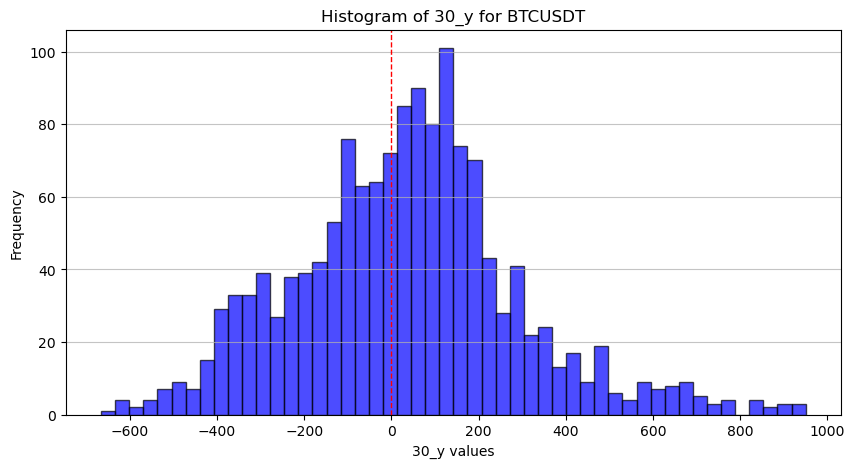

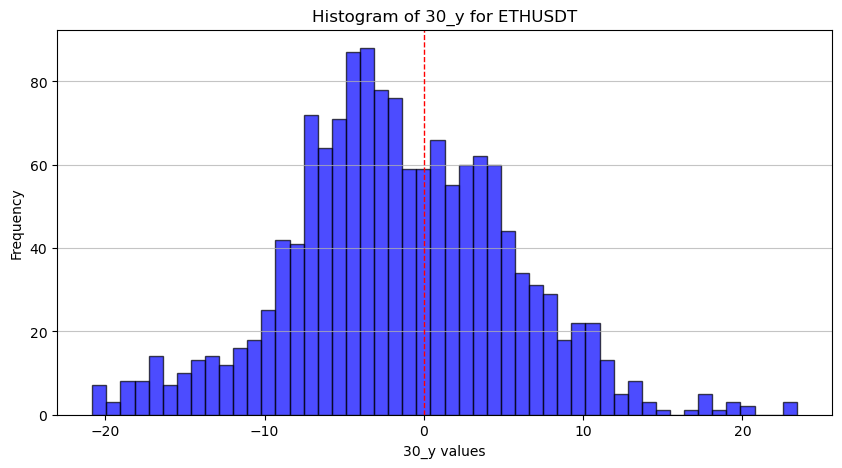

In [17]:
# # want to draw a histogram of the y values for a specific symbol
import matplotlib.pyplot as plt

def plot_y_histogram(symbol: str, y_column: str = '30_y', bins: int = 50):
    """
    Plot histogram of target y values for a specific cryptocurrency symbol.

    Args:
        symbol (str): Cryptocurrency symbol to visualize (e.g., 'BTCUSDT', 'ETHUSDT')
        y_column (str): The y column to plot (default '30_y')
        bins (int): Number of histogram bins (default 50)
    """
    # Filter data for the specific symbol
    symbol_data = df_y[df_y['symbol'] == symbol]

    if symbol_data.empty:
        print(f"No data found for symbol: {symbol}")
        return

    if y_column not in symbol_data.columns:
        print(f"Column {y_column} not found in data.")
        return

    # Drop NaN values in the specified y column
    y_values = symbol_data[y_column].dropna()

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(y_values, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f'Histogram of {y_column} for {symbol}')
    plt.xlabel(f'{y_column} values')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.axvline(0, color='red', linestyle='--', linewidth=1.0)
    plt.show()

# Example usage: Plot histogram for BTCUSDT and ETHUSDT
plot_y_histogram('BTCUSDT', y_column='30_y', bins=50)
plot_y_histogram('ETHUSDT', y_column='30_y', bins=50)